In [1]:
import datetime
import pandas as pd
import numpy as np
import pingouin
import seaborn as sns

from scipy import stats
from matplotlib import pyplot as plt

## Read Experiments From Results File
You can replace the date variable for the date the results were generated

In [2]:
date = datetime.datetime.today().strftime('%Y-%m-%d')

In [3]:
results_path = '../../results/'+date+'_results_hype.csv'
all_experiments = pd.read_csv(results_path)

## Exploring the Data

### Selecting experiments with LOSO and Bfill Window

In [4]:
k_1_bfill = all_experiments.loc[(all_experiments['k'] == 1) & (all_experiments['time_delta_type'] == 'bfill')]
k_1_bfill.shape

(72, 57)

In [5]:
k_1_bfill[['bp_pairs', 'subjects', 'mean_train_size', 'mean_test_size', 'experiment_type', 
           'predicted_variable', 'features']].groupby(['experiment_type', 'predicted_variable']).describe()

bp_pairs                                \
                                      count        mean        std    min   
experiment_type predicted_variable                                          
24 Hours        DBP                    18.0  215.055556  59.858138  132.0   
                SBP                    18.0  215.055556  59.858138  132.0   
biking          DBP                    18.0   46.944444  10.183448   32.0   
                SBP                    18.0   46.944444  10.183448   32.0   

                                                                 subjects  \
                                       25%    50%     75%    max    count   
experiment_type predicted_variable                                          
24 Hours        DBP                 173.75  202.0  265.50  311.0     18.0   
                SBP                 173.75  202.0  265.50  311.0     18.0   
biking          DBP                  36.75   48.5   54.75   61.0     18.0   
                SBP                  36.75   48.5   54.75   61.0     18.0   

                                              ... mean_test_size        \
                                        mean  ...            75%   max   
experiment_type predicted_variable            ...                        
24 Hours        DBP                 9.000000  ...           29.5  35.0   
                SBP                 9.000000  ...           29.5  35.0   
biking          DBP                 7.777778  ...            7.0   8.0   
                SBP                 7.777778  ...            7.0   8.0   

                                   features                                  \
                                      count       mean       std  min   25%   
experiment_type predicted_variable                                            
24 Hours        DBP                    18.0  11.388889  4.487091  5.0  8.25   
                SBP                    18.0  11.388889  4.487091  5.0  8.25   
biking          DBP                    18.0   4.055556  1.513555  2.0  3.00   
                SBP                    18.0   4.055556  1.513555  2.0  3.00   

                                                       
                                     50%    75%   max  
experiment_type predicted_variable                     
24 Hours        DBP                 11.0  15.00  20.0  
                SBP                 11.0  15.00  20.0  
biking          DBP                  4.0   4.75   9.0  
                SBP                  4.0   4.75   9.0  

[4 rows x 40 columns]

### Turning model columns into rows for simplifying the anaylisis

In [6]:
gbm = k_1_bfill[['predicted_variable','experiment_type','MAE_GBM_MEAN','MAE_GBM_STD','special_filter','time_delta','time_delta_type','motion_filter','bp_pairs','mean_train_size','mean_test_size','subjects','features']].sort_values(by=['predicted_variable','experiment_type','special_filter','time_delta','time_delta_type','motion_filter'])
lr = k_1_bfill[['predicted_variable','experiment_type','MAE_LR_MEAN','MAE_LR_STD','special_filter','time_delta','time_delta_type','motion_filter','bp_pairs','mean_train_size','mean_test_size','subjects','features']].sort_values(by=['predicted_variable','experiment_type','special_filter','time_delta','time_delta_type','motion_filter'])
lgbm = k_1_bfill[['predicted_variable','experiment_type','MAE_LGBM_MEAN','MAE_LGBM_STD','special_filter','time_delta','time_delta_type','motion_filter','bp_pairs','mean_train_size','mean_test_size','subjects','features']].sort_values(by=['predicted_variable','experiment_type','special_filter','time_delta','time_delta_type','motion_filter'])
rf = k_1_bfill[['predicted_variable','experiment_type','MAE_RF_MEAN','MAE_RF_STD','special_filter','time_delta','time_delta_type','motion_filter','bp_pairs','mean_train_size','mean_test_size','subjects','features']].sort_values(by=['predicted_variable','experiment_type','special_filter','time_delta','time_delta_type','motion_filter'])
d = k_1_bfill[['predicted_variable','experiment_type','MAE_DUMMY_MEAN','MAE_DUMMY_STD','special_filter','time_delta','time_delta_type','motion_filter','bp_pairs','mean_train_size','mean_test_size','subjects','features']].sort_values(by=['predicted_variable','experiment_type','special_filter','time_delta','time_delta_type','motion_filter'])

In [7]:
gbm.reset_index(drop=True, inplace=True)
gbm['model_name'] = 'gbm'
gbm.reset_index(inplace=True)
gbm.rename(columns={'MAE_GBM_MEAN': 'mae_mean', 'MAE_GBM_STD': 'mae_std', 'index': 'experiment'}, inplace=True)
gbm.shape

(72, 15)

In [8]:
lr.reset_index(drop=True, inplace=True)
lr['model_name'] = 'lr'
lr.reset_index(inplace=True)
lr.rename(columns={'MAE_LR_MEAN': 'mae_mean', 'MAE_LR_STD': 'mae_std', 'index': 'experiment'}, inplace=True)
lr.shape

(72, 15)

In [9]:
lgbm.reset_index(drop=True, inplace=True)
lgbm['model_name'] = 'lgbm'
lgbm.reset_index(inplace=True)
lgbm.rename(columns={'MAE_LGBM_MEAN': 'mae_mean', 'MAE_LGBM_STD': 'mae_std', 'index': 'experiment'}, inplace=True)
lgbm.shape

(72, 15)

In [10]:
rf.reset_index(inplace=True, drop=True)
rf['model_name'] = 'rf'
rf.reset_index(inplace=True)
rf.rename(columns={'MAE_RF_MEAN': 'mae_mean', 'MAE_RF_STD': 'mae_std', 'index': 'experiment'}, inplace=True)
rf.shape

(72, 15)

In [11]:
d.reset_index(drop=True, inplace=True)
d['model_name'] = 'dummy'
d.reset_index(inplace=True)
d.rename(columns={'MAE_DUMMY_MEAN': 'mae_mean', 'MAE_DUMMY_STD': 'mae_std', 'index': 'experiment'}, inplace=True)
d.shape

(72, 15)

In [12]:
all_models = rf.append(d, ignore_index=True)
all_models = all_models.append(lr, ignore_index=True)
all_models = all_models.append(lgbm, ignore_index=True)
all_models = all_models.append(gbm, ignore_index=True)
all_models.shape

(360, 15)

### Breaking by Experiment and Type of BP

In [13]:
all_models_24_sbp = all_models.loc[(all_models['experiment_type'] == '24 Hours') & (all_models['predicted_variable'] == 'SBP')].sort_values(by=['experiment'])
all_models_24_dbp = all_models.loc[(all_models['experiment_type'] == '24 Hours') & (all_models['predicted_variable'] == 'DBP')].sort_values(by=['experiment'])
all_models_biking_sbp = all_models.loc[(all_models['experiment_type'] == 'biking') & (all_models['predicted_variable'] == 'SBP')].sort_values(by=['experiment'])
all_models_biking_dbp = all_models.loc[(all_models['experiment_type'] == 'biking') & (all_models['experiment_type'] == 'biking') & (all_models['predicted_variable'] == 'DBP')].sort_values(by=['experiment'])

In [14]:
all_models_24_sbp.groupby('model_name')[['experiment']].count()

,experiment
model_name,
dummy,18
gbm,18
lgbm,18
lr,18
rf,18


### Test for Normality of the data

In [15]:
display(pingouin.normality(data=all_models_24_sbp, dv='mae_mean', group='model_name'))
display(pingouin.normality(data=all_models_24_dbp, dv='mae_mean', group='model_name'))
display(pingouin.normality(data=all_models_biking_sbp, dv='mae_mean', group='model_name'))
display(pingouin.normality(data=all_models_biking_dbp, dv='mae_mean', group='model_name'))

,W,pval,normal
rf,0.936712,0.254371,True
lr,0.816623,0.002634,False
lgbm,0.842848,0.006545,False
dummy,0.890920,0.040020,False
gbm,0.809994,0.002110,False


,W,pval,normal
rf,0.950195,0.428078,True
lr,0.906107,0.073481,True
lgbm,0.946616,0.374421,True
dummy,0.981276,0.962208,True
gbm,0.898398,0.053885,True


,W,pval,normal
rf,0.939338,0.282316,True
lr,0.970749,0.811658,True
lgbm,0.946969,0.379473,True
dummy,0.960923,0.619542,True
gbm,0.895687,0.048357,False


,W,pval,normal
rf,0.951918,0.455899,True
lr,0.926820,0.170677,True
lgbm,0.972694,0.846539,True
dummy,0.946410,0.371504,True
gbm,0.941588,0.308424,True


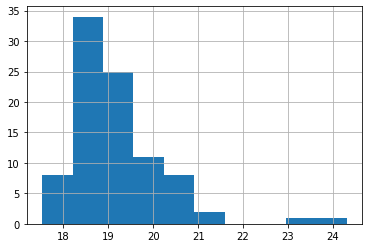

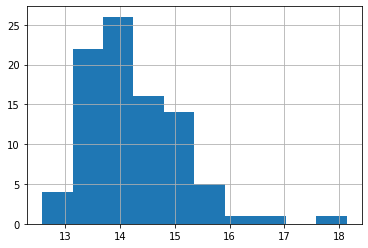

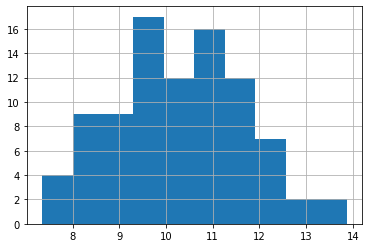

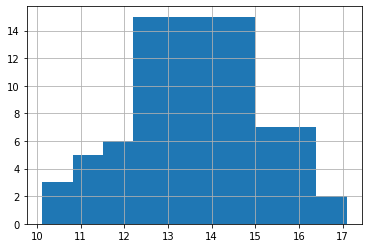

In [16]:
all_models_24_sbp['mae_mean'].hist()
plt.show()
all_models_24_dbp['mae_mean'].hist()
plt.show()
all_models_biking_dbp['mae_mean'].hist()
plt.show()
all_models_biking_sbp['mae_mean'].hist()
plt.show()

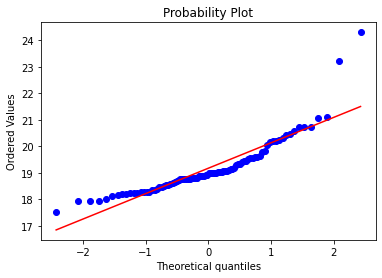

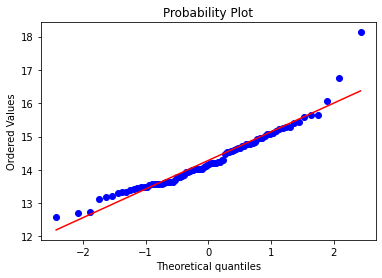

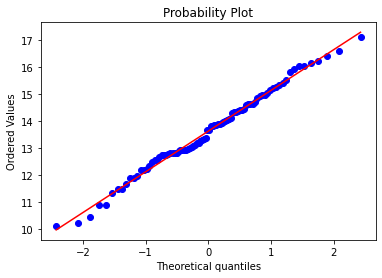

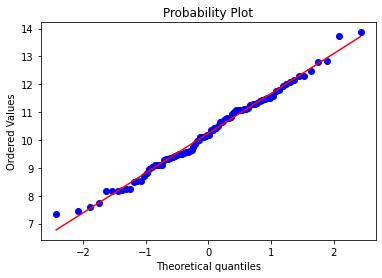

In [17]:
stats.probplot(all_models_24_sbp['mae_mean'], dist="norm", plot=plt)
plt.show()
stats.probplot(all_models_24_dbp['mae_mean'], dist="norm", plot=plt)
plt.show()
stats.probplot(all_models_biking_sbp['mae_mean'], dist="norm", plot=plt)
plt.show()
stats.probplot(all_models_biking_dbp['mae_mean'], dist="norm", plot=plt)
plt.show()

### Descriptive Statistic

### Data in Table 3

In [18]:
print('------------------------')
print("\n24 HOURS - MAE MEAN")
display(all_models_24_sbp[['mae_mean', 'mae_std', 'experiment_type', 'predicted_variable', 'model_name']].groupby(
    ['experiment_type','predicted_variable','model_name']).mean().round(2).sort_values(by=['mae_mean', 'mae_std']))
display(all_models_24_dbp[['mae_mean', 'mae_std', 'experiment_type', 'predicted_variable', 'model_name']].groupby(
    ['experiment_type','predicted_variable','model_name']).mean().round(2).sort_values(by=['mae_mean', 'mae_std']))
print('\n------------------------')
print("\nBIKING - MAE MEAN")
display(all_models_biking_sbp[['mae_mean', 'mae_std', 'experiment_type', 'predicted_variable', 'model_name']].groupby(
    ['experiment_type','predicted_variable','model_name']).mean().round(2).sort_values(by=['mae_mean']))
display(all_models_biking_dbp[['mae_mean', 'mae_std', 'experiment_type', 'predicted_variable', 'model_name']].groupby(
    ['experiment_type','predicted_variable','model_name']).mean().round(2).sort_values(by=['mae_mean', 'mae_std']))

------------------------

24 HOURS - MAE MEAN


mae_mean  mae_std
experiment_type predicted_variable model_name                   
24 Hours        SBP                lgbm           18.72     7.15
                                   gbm            18.83     7.13
                                   rf             18.88     6.56
                                   dummy          19.31     7.95
                                   lr             20.14     8.77

mae_mean  mae_std
experiment_type predicted_variable model_name                   
24 Hours        DBP                rf             13.75     4.34
                                   lgbm           13.81     5.20
                                   gbm            13.95     5.13
                                   dummy          14.68     5.95
                                   lr             15.22     6.64


------------------------

BIKING - MAE MEAN


mae_mean  mae_std
experiment_type predicted_variable model_name                   
biking          SBP                lgbm           12.90     6.66
                                   dummy          13.01     6.60
                                   lr             13.74     7.12
                                   gbm            13.90     6.48
                                   rf             14.55     6.62

mae_mean  mae_std
experiment_type predicted_variable model_name                   
biking          DBP                lgbm            9.59     4.86
                                   dummy           9.63     4.60
                                   lr             10.09     5.08
                                   gbm            10.84     4.82
                                   rf             11.07     4.88

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(1, 0, '(DBP, dummy)'),
  Text(2, 0, '(DBP, gbm)'),
  Text(3, 0, '(DBP, lgbm)'),
  Text(4, 0, '(DBP, lr)'),
  Text(5, 0, '(DBP, rf)'),
  Text(6, 0, '(SBP, dummy)'),
  Text(7, 0, '(SBP, gbm)'),
  Text(8, 0, '(SBP, lgbm)'),
  Text(9, 0, '(SBP, lr)'),
  Text(10, 0, '(SBP, rf)')])

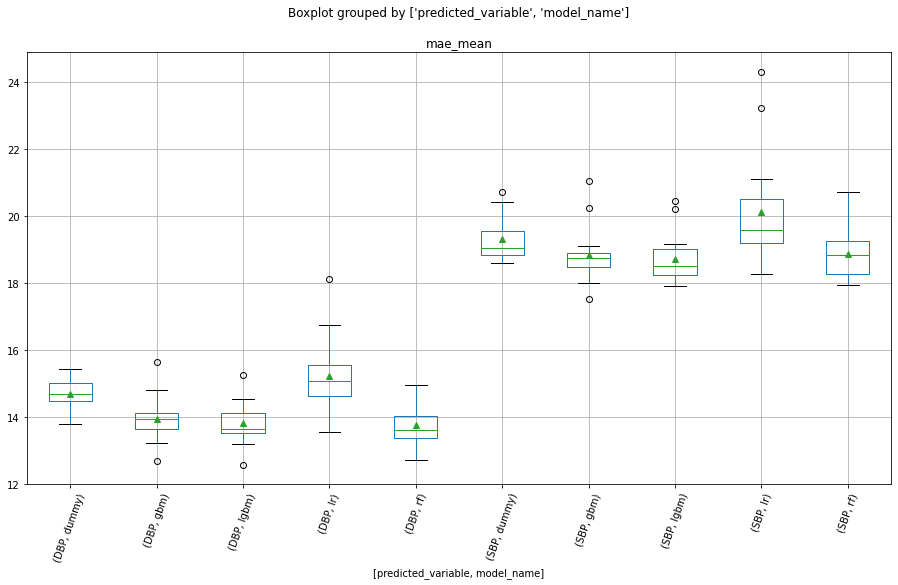

In [19]:
all_models.loc[all_models['experiment_type'] == '24 Hours'].boxplot(column=['mae_mean'], by=['predicted_variable', 'model_name'], showmeans=True, figsize=(15,8))
plt.xticks(rotation=70)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(1, 0, '(DBP, dummy)'),
  Text(2, 0, '(DBP, gbm)'),
  Text(3, 0, '(DBP, lgbm)'),
  Text(4, 0, '(DBP, lr)'),
  Text(5, 0, '(DBP, rf)'),
  Text(6, 0, '(SBP, dummy)'),
  Text(7, 0, '(SBP, gbm)'),
  Text(8, 0, '(SBP, lgbm)'),
  Text(9, 0, '(SBP, lr)'),
  Text(10, 0, '(SBP, rf)')])

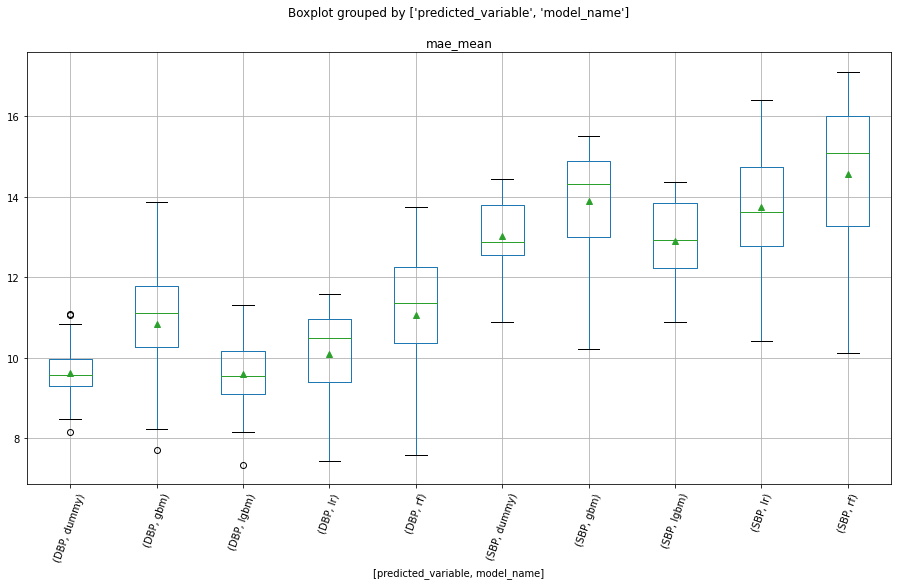

In [20]:
all_models.loc[all_models['experiment_type'] == 'biking'].boxplot(column=['mae_mean'], 
                    by=['predicted_variable', 'model_name'], showmeans=True, figsize=(15,8))
plt.xticks(rotation=70)

### Check for significant differences in the means 

In [21]:
display(pingouin.sphericity(data=all_models_24_sbp, dv='mae_mean', 
                            within='model_name', subject='experiment', method='jns'))
display(pingouin.sphericity(data=all_models_24_dbp, dv='mae_mean', within='model_name', 
                            subject='experiment', method='jns'))
display(pingouin.sphericity(data=all_models_biking_sbp, dv='mae_mean', 
                            within='model_name', subject='experiment', method='jns'))
display(pingouin.sphericity(data=all_models_biking_dbp, dv='mae_mean', 
                            within='model_name', subject='experiment', method='jns'))

SpherResults(spher=False, W=1.389968760214649, chi2=164.15550147090948, dof=9, pval=1.0160535754345551e-30)

SpherResults(spher=False, W=1.6197573529920066, chi2=197.24505883084896, dof=9, pval=1.2519305623027085e-37)

SpherResults(spher=False, W=2.218065093808798, chi2=283.40137350846686, dof=9, pval=8.61220941331902e-56)

SpherResults(spher=False, W=1.9502408139794187, chi2=244.8346772130363, dof=9, pval=1.2277882105857924e-47)

In [22]:
display(all_models_24_sbp['mae_mean'].loc[np.abs(stats.zscore(all_models_24_sbp['mae_mean'])) > 3])
display(all_models_24_dbp['mae_mean'].loc[np.abs(stats.zscore(all_models_24_dbp['mae_mean'])) > 3])
display(all_models_biking_sbp['mae_mean'].loc[np.abs(stats.zscore(all_models_biking_sbp['mae_mean'])) > 3])
display(all_models_biking_dbp['mae_mean'].loc[np.abs(stats.zscore(all_models_biking_dbp['mae_mean'])) > 3])

187    23.221036
190    24.303410
Name: mae_mean, dtype: float64

154    18.131318
Name: mae_mean, dtype: float64

Series([], Name: mae_mean, dtype: float64)

Series([], Name: mae_mean, dtype: float64)

In [23]:
display(pingouin.rm_anova(data=all_models_24_sbp, dv='mae_mean', subject='experiment', 
                          within=['model_name'], detailed=True, correction=True))

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,model_name,24.451038,4,6.112760,10.847941,7.344178e-07,0.001352,0.389542,0.347492,False,0.023865,4.989592e-09
1,Error,38.317654,68,0.563495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
stats.friedmanchisquare(all_models_24_sbp['mae_mean'].loc[all_models_24_sbp['model_name'] == 'gbm'], 
                       all_models_24_sbp['mae_mean'].loc[all_models_24_sbp['model_name'] == 'lgbm'],
                       all_models_24_sbp['mae_mean'].loc[all_models_24_sbp['model_name'] == 'rf'],
                       all_models_24_sbp['mae_mean'].loc[all_models_24_sbp['model_name'] == 'lr'],
                       all_models_24_sbp['mae_mean'].loc[all_models_24_sbp['model_name'] == 'dummy'])

FriedmanchisquareResult(statistic=36.80000000000001, pvalue=1.9805383803779305e-07)

In [25]:
display(pingouin.rm_anova(data=all_models_24_dbp, dv='mae_mean', subject='experiment', 
                          within=['model_name'], detailed=True, correction=True))

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,model_name,29.822892,4,7.455723,24.167418,1.827369e-12,0.000003,0.587052,0.404939,False,0.027351,1.239753e-08
1,Error,20.978209,68,0.308503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
stats.friedmanchisquare(all_models_24_dbp['mae_mean'].loc[all_models_24_dbp['model_name'] == 'gbm'], 
                       all_models_24_dbp['mae_mean'].loc[all_models_24_dbp['model_name'] == 'lgbm'],
                       all_models_24_dbp['mae_mean'].loc[all_models_24_dbp['model_name'] == 'rf'],
                       all_models_24_dbp['mae_mean'].loc[all_models_24_dbp['model_name'] == 'lr'],
                       all_models_24_dbp['mae_mean'].loc[all_models_24_dbp['model_name'] == 'dummy'])

FriedmanchisquareResult(statistic=51.02222222222224, pvalue=2.208478354823916e-10)

In [27]:
display(pingouin.rm_anova(data=all_models_biking_sbp, dv='mae_mean', subject='experiment', within=['model_name'], detailed=True, correction=True))

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,model_name,33.468974,4,8.367243,18.11944,3.587561e-10,0.000002,0.515938,0.554516,False,0.150987,0.000657
1,Error,31.401222,68,0.461783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
stats.friedmanchisquare(all_models_biking_sbp['mae_mean'].loc[all_models_biking_sbp['model_name'] == 'gbm'], 
                       all_models_biking_sbp['mae_mean'].loc[all_models_biking_sbp['model_name'] == 'lgbm'],
                       all_models_biking_sbp['mae_mean'].loc[all_models_biking_sbp['model_name'] == 'rf'],
                       all_models_biking_sbp['mae_mean'].loc[all_models_biking_sbp['model_name'] == 'lr'],
                       all_models_biking_sbp['mae_mean'].loc[all_models_biking_sbp['model_name'] == 'dummy'])

FriedmanchisquareResult(statistic=32.18079096045198, pvalue=1.7570420040898164e-06)

In [29]:
display(pingouin.rm_anova(data=all_models_biking_dbp, dv='mae_mean', subject='experiment', 
                          within=['model_name'], detailed=True, correction=True))

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,model_name,33.672029,4,8.418007,17.58903,5.936905e-10,0.000007,0.508515,0.48756,False,0.052416,8.925449e-07
1,Error,32.544404,68,0.478594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
stats.friedmanchisquare(all_models_biking_dbp['mae_mean'].loc[all_models_biking_dbp['model_name'] == 'gbm'], 
                       all_models_biking_dbp['mae_mean'].loc[all_models_biking_dbp['model_name'] == 'lgbm'],
                       all_models_biking_dbp['mae_mean'].loc[all_models_biking_dbp['model_name'] == 'rf'],
                       all_models_biking_dbp['mae_mean'].loc[all_models_biking_dbp['model_name'] == 'lr'],
                       all_models_biking_dbp['mae_mean'].loc[all_models_biking_dbp['model_name'] == 'dummy'])

FriedmanchisquareResult(statistic=40.58757062146891, pvalue=3.271703161824074e-08)

## Pairwise Tests

### Data in Table 4

### 24 Hours SBP

In [31]:
result_all_models_24_sbp = pingouin.pairwise_ttests(data=all_models_24_sbp, dv='mae_mean',
                                                    subject='experiment', 
                                                    within='model_name',
                                                    padjust='holm')
result_all_models_24_sbp.round(2).sort_values(by=['A','B'])

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,model_name,dummy,gbm,True,True,4.80,17.0,two-sided,0.00,0.00,holm,179.014,0.67
1,model_name,dummy,lgbm,True,True,5.62,17.0,two-sided,0.00,0.00,holm,813.453,0.87
2,model_name,dummy,lr,True,True,-2.22,17.0,two-sided,0.04,0.16,holm,1.697,-0.70
3,model_name,dummy,rf,True,True,2.96,17.0,two-sided,0.01,0.04,holm,5.905,0.62
4,model_name,gbm,lgbm,True,True,1.25,17.0,two-sided,0.23,0.68,holm,0.479,0.15
5,model_name,gbm,lr,True,True,-3.44,17.0,two-sided,0.00,0.02,holm,14.091,-1.07
6,model_name,gbm,rf,True,True,-0.32,17.0,two-sided,0.76,0.76,holm,0.254,-0.05
7,model_name,lgbm,lr,True,True,-3.77,17.0,two-sided,0.00,0.01,holm,25.779,-1.18
8,model_name,lgbm,rf,True,True,-1.16,17.0,two-sided,0.26,0.68,holm,0.437,-0.21
9,model_name,lr,rf,True,True,3.72,17.0,two-sided,0.00,0.01,holm,23.455,1.04


In [32]:
result_all_models_24_sbp.loc[(result_all_models_24_sbp.A == 'lgbm') | (result_all_models_24_sbp.B == 'lgbm')]

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
1,model_name,dummy,lgbm,True,True,5.622564,17.0,two-sided,0.000030,0.000304,holm,813.453,0.872250
4,model_name,gbm,lgbm,True,True,1.254907,17.0,two-sided,0.226491,0.679472,holm,0.479,0.149160
7,model_name,lgbm,lr,True,True,-3.766633,17.0,two-sided,0.001538,0.012307,holm,25.779,-1.181204
8,model_name,lgbm,rf,True,True,-1.164674,17.0,two-sided,0.260235,0.679472,holm,0.437,-0.210386


### 24 Hours DBP

In [33]:
result_all_models_24_dbp = pingouin.pairwise_ttests(data=all_models_24_dbp, dv='mae_mean', 
                         subject='experiment', within=['model_name'], padjust='holm')
result_all_models_24_dbp.round(2).sort_values(by=['A','B'])

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,model_name,dummy,gbm,True,True,8.29,17.0,two-sided,0.00,0.00,holm,6.961e+04,1.36
1,model_name,dummy,lgbm,True,True,9.20,17.0,two-sided,0.00,0.00,holm,2.704e+05,1.66
2,model_name,dummy,lr,True,True,-1.98,17.0,two-sided,0.06,0.19,holm,1.192,-0.67
3,model_name,dummy,rf,True,True,6.53,17.0,two-sided,0.00,0.00,holm,4025.943,1.76
4,model_name,gbm,lgbm,True,True,3.00,17.0,two-sided,0.01,0.03,holm,6.354,0.22
5,model_name,gbm,lr,True,True,-4.71,17.0,two-sided,0.00,0.00,holm,151.257,-1.48
6,model_name,gbm,rf,True,True,1.54,17.0,two-sided,0.14,0.29,holm,0.658,0.31
7,model_name,lgbm,lr,True,True,-5.39,17.0,two-sided,0.00,0.00,holm,533.801,-1.65
8,model_name,lgbm,rf,True,True,0.46,17.0,two-sided,0.65,0.65,holm,0.267,0.10
9,model_name,lr,rf,True,True,6.20,17.0,two-sided,0.00,0.00,holm,2281.136,1.72


In [34]:
result_all_models_24_dbp.loc[(result_all_models_24_dbp.A == 'lgbm') | (result_all_models_24_dbp.B == 'lgbm')]

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
1,model_name,dummy,lgbm,True,True,9.204467,17.0,two-sided,5.144464e-08,5.144464e-07,holm,2.704e+05,1.655916
4,model_name,gbm,lgbm,True,True,3.002328,17.0,two-sided,8.014814e-03,3.205926e-02,holm,6.354,0.218072
7,model_name,lgbm,lr,True,True,-5.390766,17.0,two-sided,4.878911e-05,2.927347e-04,holm,533.801,-1.653762
8,model_name,lgbm,rf,True,True,0.461315,17.0,two-sided,6.504203e-01,6.504203e-01,holm,0.267,0.097893


### Biking SBP

In [35]:
result_all_models_biking_sbp = pingouin.pairwise_ttests(data=all_models_biking_sbp, 
                                                       dv='mae_mean', subject='experiment', 
                                                       within='model_name', padjust='holm')

result_all_models_biking_sbp.round(2).sort_values(by=['A','B'])

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,model_name,dummy,gbm,True,True,-4.52,17.0,two-sided,0.00,0.00,holm,105.326,-0.72
1,model_name,dummy,lgbm,True,True,0.77,17.0,two-sided,0.45,0.87,holm,0.316,0.11
2,model_name,dummy,lr,True,True,-3.23,17.0,two-sided,0.00,0.01,holm,9.514,-0.55
3,model_name,dummy,rf,True,True,-4.81,17.0,two-sided,0.00,0.00,holm,182.055,-1.03
4,model_name,gbm,lgbm,True,True,5.08,17.0,two-sided,0.00,0.00,holm,303.487,0.80
5,model_name,gbm,lr,True,True,0.80,17.0,two-sided,0.43,0.87,holm,0.322,0.10
6,model_name,gbm,rf,True,True,-3.89,17.0,two-sided,0.00,0.01,holm,32.204,-0.40
7,model_name,lgbm,lr,True,True,-3.41,17.0,two-sided,0.00,0.01,holm,13.416,-0.63
8,model_name,lgbm,rf,True,True,-5.72,17.0,two-sided,0.00,0.00,holm,969.681,-1.09
9,model_name,lr,rf,True,True,-3.66,17.0,two-sided,0.00,0.01,holm,21.022,-0.47


In [36]:
result_all_models_biking_sbp.loc[(result_all_models_biking_sbp.A == 'lgbm') | (result_all_models_biking_sbp.B == 'lgbm')]

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
1,model_name,dummy,lgbm,True,True,0.771449,17.0,two-sided,0.451032,0.869844,holm,0.316,0.109333
4,model_name,gbm,lgbm,True,True,5.083631,17.0,two-sided,0.000092,0.000828,holm,303.487,0.795435
7,model_name,lgbm,lr,True,True,-3.414731,17.0,two-sided,0.003301,0.013203,holm,13.416,-0.629346
8,model_name,lgbm,rf,True,True,-5.719995,17.0,two-sided,0.000025,0.000250,holm,969.681,-1.091272


### Biking DBP

In [37]:
result_all_models_biking_dbp = pingouin.pairwise_ttests(data=all_models_biking_dbp, dv='mae_mean', 
                                                        subject='experiment', within='model_name', padjust='holm')

result_all_models_biking_dbp.round(2).sort_values(by=['A','B'])

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,model_name,dummy,gbm,True,True,-4.56,17.0,two-sided,0.00,0.00,holm,114.284,-0.96
1,model_name,dummy,lgbm,True,True,0.34,17.0,two-sided,0.74,0.74,holm,0.256,0.04
2,model_name,dummy,lr,True,True,-2.40,17.0,two-sided,0.03,0.11,holm,2.286,-0.44
3,model_name,dummy,rf,True,True,-4.87,17.0,two-sided,0.00,0.00,holm,203.38,-1.06
4,model_name,gbm,lgbm,True,True,5.71,17.0,two-sided,0.00,0.00,holm,950.307,0.92
5,model_name,gbm,lr,True,True,2.62,17.0,two-sided,0.02,0.09,holm,3.285,0.54
6,model_name,gbm,rf,True,True,-2.00,17.0,two-sided,0.06,0.12,holm,1.233,-0.13
7,model_name,lgbm,lr,True,True,-2.33,17.0,two-sided,0.03,0.11,holm,2.032,-0.43
8,model_name,lgbm,rf,True,True,-6.45,17.0,two-sided,0.00,0.00,holm,3519.313,-1.02
9,model_name,lr,rf,True,True,-3.44,17.0,two-sided,0.00,0.02,holm,14.086,-0.66


In [38]:
result_all_models_biking_dbp.loc[(result_all_models_biking_dbp.A == 'lgbm') | (result_all_models_biking_dbp.B == 'lgbm')]

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
1,model_name,dummy,lgbm,True,True,0.342122,17.0,two-sided,0.736452,0.736452,holm,0.256,0.040757
4,model_name,gbm,lgbm,True,True,5.708778,17.0,two-sided,0.000026,0.000230,holm,950.307,0.921219
7,model_name,lgbm,lr,True,True,-2.330314,17.0,two-sided,0.032364,0.111714,holm,2.032,-0.428988
8,model_name,lgbm,rf,True,True,-6.451048,17.0,two-sided,0.000006,0.000060,holm,3519.313,-1.020710


# Parameters

In [39]:
lgbm_24_sbp = lgbm.loc[(lgbm['experiment_type'] == '24 Hours') & (lgbm['predicted_variable'] == 'SBP')].sort_values(by=['motion_filter','time_delta','special_filter'])
lgbm_24_dbp = lgbm.loc[(lgbm['experiment_type'] == '24 Hours') & (lgbm['predicted_variable'] == 'DBP')].sort_values(by=['motion_filter','time_delta','special_filter'])
lgbm_biking_sbp = lgbm.loc[(lgbm['experiment_type'] == 'biking') & (lgbm['predicted_variable'] == 'SBP')].sort_values(by=['motion_filter','time_delta','special_filter'])
lgbm_biking_dbp = lgbm.loc[(lgbm['experiment_type'] == 'biking') & (lgbm['predicted_variable'] == 'DBP')].sort_values(by=['motion_filter','time_delta','special_filter'])

## Filters

,mae_mean
special_filter,
cheby,18.516082
norm,18.764497
butter,18.883870


,W,pval,normal
butter,0.834184,0.116589,True
cheby,0.805524,0.065861,True
norm,0.909346,0.432107,True


F_onewayResult(statistic=0.4087827972150798, pvalue=0.6716408645235773)

(array([1, 2, 3]),
 [Text(1, 0, 'butter'), Text(2, 0, 'cheby'), Text(3, 0, 'norm')])

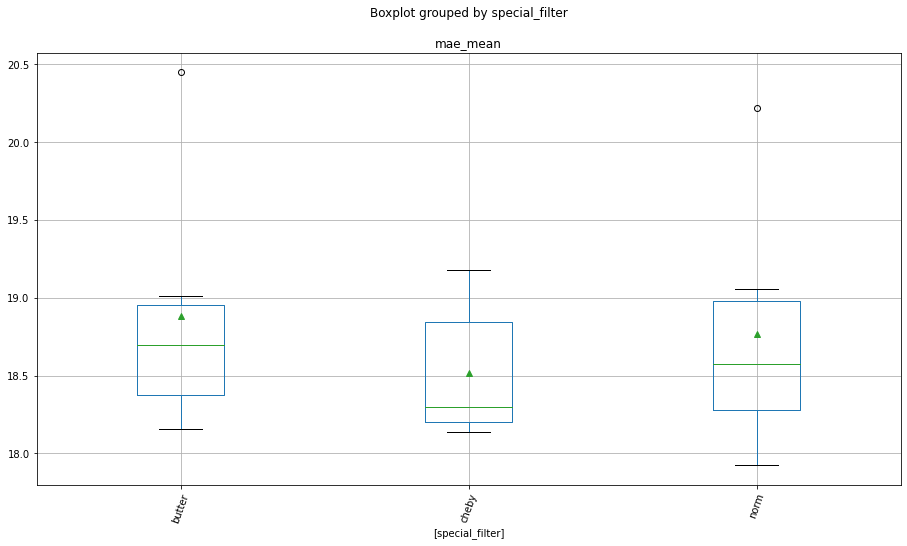

In [40]:
display(lgbm_24_sbp[['special_filter', 'mae_mean']].groupby(['special_filter']).mean().sort_values(by=['mae_mean']))

display(pingouin.normality(data=lgbm_24_sbp, dv='mae_mean', group='special_filter'))

display(stats.f_oneway(lgbm_24_sbp.loc[lgbm_24_sbp['special_filter'] == 'butter']['mae_mean'], 
               lgbm_24_sbp.loc[lgbm_24_sbp['special_filter'] == 'norm']['mae_mean'],
              lgbm_24_sbp.loc[lgbm_24_sbp['special_filter'] == 'cheby']['mae_mean']))

lgbm_24_sbp[['experiment_type', 'predicted_variable', 'special_filter', 'mae_mean']].boxplot(
    column=['mae_mean'], by=['special_filter'], showmeans=True, figsize=(15,8))
plt.xticks(rotation=70)

,mae_mean
special_filter,
cheby,13.626255
norm,13.761401
butter,14.051942


,W,pval,normal
butter,0.824721,0.096914,True
cheby,0.904388,0.400514,True
norm,0.936139,0.628273,True


F_onewayResult(statistic=0.8271590174101484, pvalue=0.4562816879355014)

(array([1, 2, 3]),
 [Text(1, 0, 'butter'), Text(2, 0, 'cheby'), Text(3, 0, 'norm')])

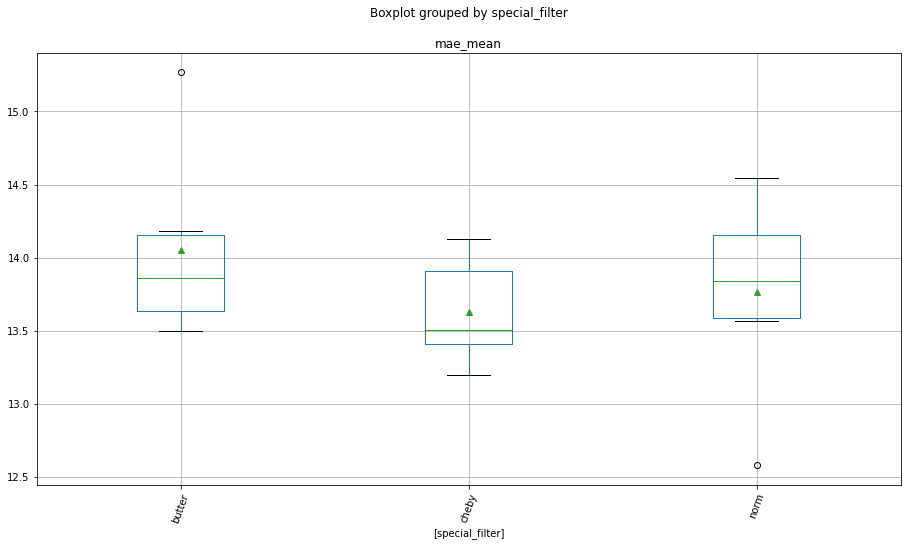

In [41]:
display(lgbm_24_dbp[['special_filter', 'mae_mean']].groupby(['special_filter']).mean().sort_values(by=['mae_mean']))

display(pingouin.normality(data=lgbm_24_dbp, dv='mae_mean', group='special_filter'))

display(stats.f_oneway(lgbm_24_dbp.loc[lgbm_24_dbp['special_filter'] == 'butter']['mae_mean'], 
               lgbm_24_dbp.loc[lgbm_24_dbp['special_filter'] == 'norm']['mae_mean'],
              lgbm_24_dbp.loc[lgbm_24_dbp['special_filter'] == 'cheby']['mae_mean']))

lgbm_24_dbp[['experiment_type', 'predicted_variable', 'special_filter', 'mae_mean']].boxplot(
    column=['mae_mean'], by=['special_filter'], showmeans=True, figsize=(15,8))
plt.xticks(rotation=70)

,mae_mean
special_filter,
cheby,12.462169
butter,12.864443
norm,13.360920


,W,pval,normal
butter,0.896153,0.351690,True
cheby,0.900720,0.378206,True
norm,0.980857,0.955739,True


F_onewayResult(statistic=1.10362709959764, pvalue=0.357147516245803)

(array([1, 2, 3]),
 [Text(1, 0, 'butter'), Text(2, 0, 'cheby'), Text(3, 0, 'norm')])

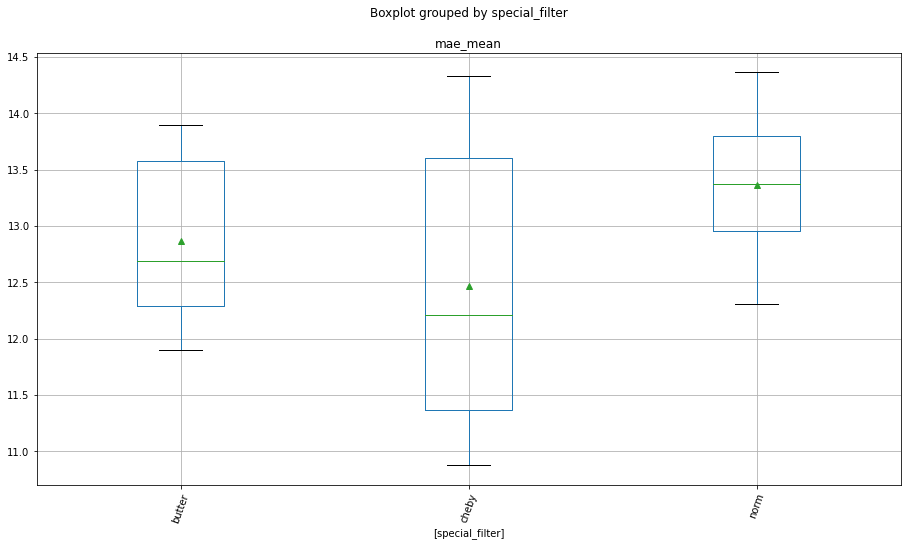

In [42]:
display(lgbm_biking_sbp[['special_filter', 'mae_mean']].groupby(['special_filter']).mean().sort_values(by=['mae_mean']))

display(pingouin.normality(data=lgbm_biking_sbp, dv='mae_mean', group='special_filter'))

display(stats.f_oneway(lgbm_biking_sbp.loc[lgbm_biking_sbp['special_filter'] == 'butter']['mae_mean'], 
               lgbm_biking_sbp.loc[lgbm_biking_sbp['special_filter'] == 'norm']['mae_mean'],
              lgbm_biking_sbp.loc[lgbm_biking_sbp['special_filter'] == 'cheby']['mae_mean']))

lgbm_biking_sbp[['experiment_type', 'predicted_variable', 'special_filter', 'mae_mean']].boxplot(
    column=['mae_mean'], by=['special_filter'], showmeans=True, figsize=(15,8))
plt.xticks(rotation=70)

,mae_mean
special_filter,
butter,9.531025
norm,9.587747
cheby,9.645216


,W,pval,normal
butter,0.834724,0.117810,True
cheby,0.915784,0.475527,True
norm,0.957370,0.799257,True


F_onewayResult(statistic=0.014927304254003555, pvalue=0.9851981712353515)

(array([1, 2, 3]),
 [Text(1, 0, 'butter'), Text(2, 0, 'cheby'), Text(3, 0, 'norm')])

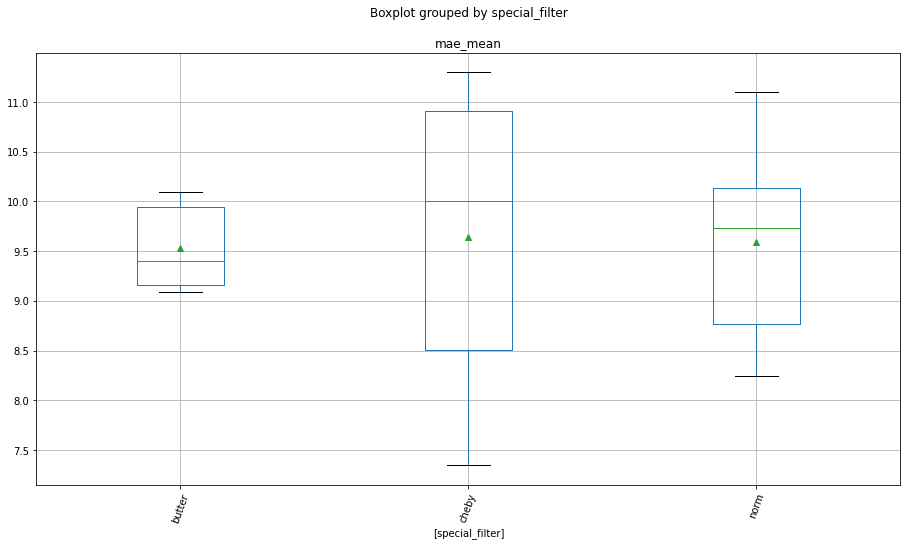

In [43]:
display(lgbm_biking_dbp[['special_filter', 'mae_mean']].groupby(['special_filter']).mean().sort_values(by=['mae_mean']))

display(pingouin.normality(data=lgbm_biking_dbp, dv='mae_mean', group='special_filter'))

display(stats.f_oneway(lgbm_biking_dbp.loc[lgbm_biking_dbp['special_filter'] == 'butter']['mae_mean'], 
               lgbm_biking_dbp.loc[lgbm_biking_dbp['special_filter'] == 'norm']['mae_mean'],
              lgbm_biking_dbp.loc[lgbm_biking_dbp['special_filter'] == 'cheby']['mae_mean']))

lgbm_biking_dbp[['experiment_type', 'predicted_variable', 'special_filter', 'mae_mean']].boxplot(
    column=['mae_mean'], by=['special_filter'], showmeans=True, figsize=(15,8))
plt.xticks(rotation=70)

# LGBM 24 Hours SBP

In [44]:
lgbm_24_sbp[['experiment_type', 'predicted_variable', 'motion_filter', 'time_delta', 'mae_mean']].groupby(
['experiment_type', 'predicted_variable', 'time_delta', 'motion_filter']).mean().sort_values(
    by=['experiment_type', 'predicted_variable', 'mae_mean', 'time_delta', 'motion_filter'])

mae_mean
experiment_type predicted_variable time_delta motion_filter           
24 Hours        SBP                15 seconds yes            18.257634
                                   45 seconds yes            18.365022
                                              no             18.515259
                                   30 seconds yes            18.570020
                                              no             18.733513
                                   15 seconds no             19.887449

(array([1, 2, 3, 4, 5, 6]),
 [Text(1, 0, '(15 seconds, no)'),
  Text(2, 0, '(15 seconds, yes)'),
  Text(3, 0, '(30 seconds, no)'),
  Text(4, 0, '(30 seconds, yes)'),
  Text(5, 0, '(45 seconds, no)'),
  Text(6, 0, '(45 seconds, yes)')])

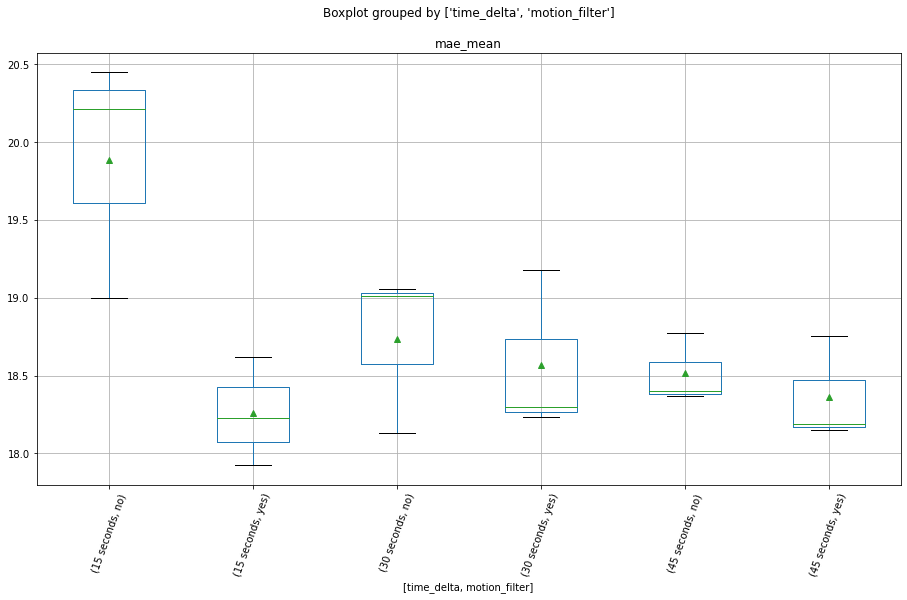

In [45]:
lgbm_24_sbp[['experiment_type', 'predicted_variable', 'motion_filter', 'time_delta', 'mae_mean']].boxplot(
    column=['mae_mean'], by=['time_delta', 'motion_filter'], showmeans=True, figsize=(15,8))
plt.xticks(rotation=70)

In [46]:
pingouin.anova(data=lgbm_24_sbp, dv='mae_mean', 
               between=['time_delta', 'motion_filter'], detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,time_delta,1.243535,2,0.621768,2.598452,0.115448,0.302200
1,motion_filter,1.888684,1,1.888684,7.893068,0.015765,0.396775
2,time_delta * motion_filter,2.169713,2,1.084857,4.533764,0.034151,0.430403
3,Residual,2.871407,12,0.239284,NaN,NaN,NaN


In [47]:
tt_lgbm_24_sbp = pingouin.pairwise_ttests(data=lgbm_24_sbp, dv='mae_mean', 
                                          between=['time_delta', 'motion_filter'], 
                                          interaction=True, return_desc=True)
tt_lgbm_24_sbp

,Contrast,time_delta,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,time_delta,-,15 seconds,30 seconds,19.072541,1.042547,18.651767,0.476002,False,True,0.899318,10.0,two-sided,0.389625,0.603,0.479281
1,time_delta,-,15 seconds,45 seconds,19.072541,1.042547,18.440140,0.269219,False,True,1.438648,10.0,two-sided,0.180804,0.87,0.766711
2,time_delta,-,30 seconds,45 seconds,18.651767,0.476002,18.440140,0.269219,False,True,0.947912,10.0,two-sided,0.365518,0.619,0.505179
3,motion_filter,-,no,yes,19.045407,0.799275,18.397559,0.383069,False,True,2.192799,16.0,two-sided,0.043449,1.891,0.984472
4,time_delta * motion_filter,15 seconds,no,yes,19.887449,0.776769,18.257634,0.348808,False,True,3.315270,4.0,two-sided,0.029509,2.681,2.165525
5,time_delta * motion_filter,30 seconds,no,yes,18.733513,0.519297,18.570020,0.526049,False,True,0.383095,4.0,two-sided,0.721138,0.587,0.250237
6,time_delta * motion_filter,45 seconds,no,yes,18.515259,0.226421,18.365022,0.336159,False,True,0.642035,4.0,two-sided,0.555796,0.632,0.419376


In [48]:
tt_lgbm_24_sbp[['time_delta','A','B','p-unc',
               'mean(A)','std(A)','mean(B)','std(B)']].round(2)

,time_delta,A,B,p-unc,mean(A),std(A),mean(B),std(B)
0,-,15 seconds,30 seconds,0.39,19.07,1.04,18.65,0.48
1,-,15 seconds,45 seconds,0.18,19.07,1.04,18.44,0.27
2,-,30 seconds,45 seconds,0.37,18.65,0.48,18.44,0.27
3,-,no,yes,0.04,19.05,0.80,18.40,0.38
4,15 seconds,no,yes,0.03,19.89,0.78,18.26,0.35
5,30 seconds,no,yes,0.72,18.73,0.52,18.57,0.53
6,45 seconds,no,yes,0.56,18.52,0.23,18.37,0.34


# LGBM 24 Hours DBP

In [49]:
lgbm_24_dbp[['experiment_type', 'predicted_variable', 'motion_filter', 'time_delta', 'mae_mean']].groupby(
['experiment_type', 'predicted_variable', 'time_delta', 'motion_filter']).mean().sort_values(
    by=['experiment_type', 'predicted_variable', 'mae_mean', 'time_delta', 'motion_filter'])

mae_mean
experiment_type predicted_variable time_delta motion_filter           
24 Hours        DBP                15 seconds yes            13.287436
                                   45 seconds no             13.547119
                                              yes            13.688367
                                   30 seconds yes            13.759034
                                              no             13.985722
                                   15 seconds no             14.611519

(array([1, 2, 3, 4, 5, 6]),
 [Text(1, 0, '(15 seconds, no)'),
  Text(2, 0, '(15 seconds, yes)'),
  Text(3, 0, '(30 seconds, no)'),
  Text(4, 0, '(30 seconds, yes)'),
  Text(5, 0, '(45 seconds, no)'),
  Text(6, 0, '(45 seconds, yes)')])

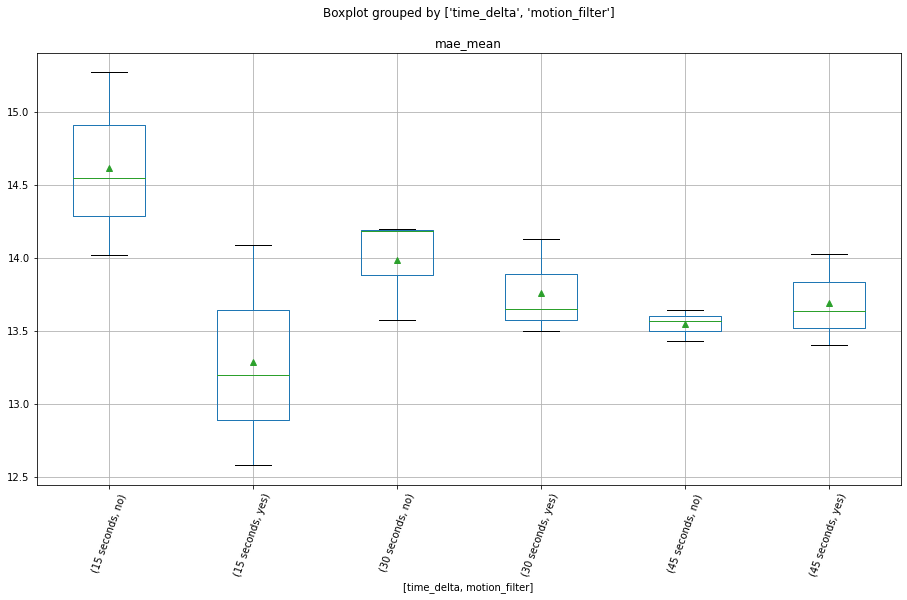

In [50]:
lgbm_24_dbp[['experiment_type', 'predicted_variable', 'motion_filter', 'time_delta', 'mae_mean']].boxplot(
    column=['mae_mean'], by=['time_delta', 'motion_filter'], showmeans=True, figsize=(15,8))
plt.xticks(rotation=70)

In [51]:
pingouin.anova(data=lgbm_24_dbp, dv='mae_mean', between=['time_delta', 'motion_filter'], ss_type=2, detailed=True, effsize='np2')

,Source,SS,DF,MS,F,p-unc,np2
0,time_delta,0.361662,2,0.180831,0.829045,0.459989,0.121400
1,motion_filter,0.993376,1,0.993376,4.554265,0.054160,0.275111
2,time_delta * motion_filter,1.743426,2,0.871713,3.996484,0.046755,0.399789
3,Residual,2.617440,12,0.218120,NaN,NaN,NaN


In [52]:
tt_lgbm_24_dbp = pingouin.pairwise_ttests(data=lgbm_24_dbp, dv='mae_mean', 
                                          between=['time_delta', 'motion_filter'], 
                                          interaction=True, return_desc=True)

In [53]:
tt_lgbm_24_dbp[['time_delta','A','B','p-unc',
               'mean(A)','std(A)','mean(B)','std(B)']].round(2)

,time_delta,A,B,p-unc,mean(A),std(A),mean(B),std(B)
0,-,15 seconds,30 seconds,0.86,13.95,0.95,13.87,0.33
1,-,15 seconds,45 seconds,0.43,13.95,0.95,13.62,0.22
2,-,30 seconds,45 seconds,0.15,13.87,0.33,13.62,0.22
3,-,no,yes,0.09,14.05,0.59,13.58,0.49
4,15 seconds,no,yes,0.08,14.61,0.63,13.29,0.76
5,30 seconds,no,yes,0.46,13.99,0.35,13.76,0.33
6,45 seconds,no,yes,0.50,13.55,0.11,13.69,0.32


# LGBM Biking SBP

In [54]:
lgbm_biking_sbp[['experiment_type', 'predicted_variable', 'motion_filter', 'time_delta', 'mae_mean']].groupby(
['experiment_type', 'predicted_variable', 'time_delta', 'motion_filter']).mean().sort_values(
    by=['experiment_type', 'predicted_variable', 'mae_mean', 'time_delta', 'motion_filter'])

mae_mean
experiment_type predicted_variable time_delta motion_filter           
biking          SBP                30 seconds yes            11.994633
                                              no             12.199061
                                   15 seconds no             12.320519
                                              yes            13.129588
                                   45 seconds no             13.535458
                                              yes            14.195805

(array([1, 2, 3, 4, 5, 6]),
 [Text(1, 0, '(15 seconds, no)'),
  Text(2, 0, '(15 seconds, yes)'),
  Text(3, 0, '(30 seconds, no)'),
  Text(4, 0, '(30 seconds, yes)'),
  Text(5, 0, '(45 seconds, no)'),
  Text(6, 0, '(45 seconds, yes)')])

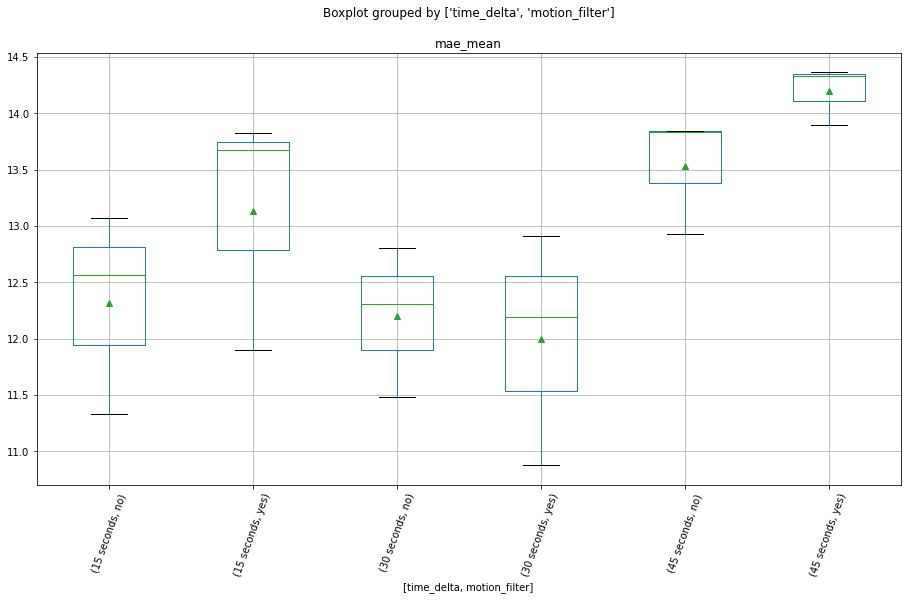

In [55]:
lgbm_biking_sbp[['experiment_type', 'predicted_variable', 'motion_filter', 'time_delta', 'mae_mean']].boxplot(
    column=['mae_mean'], by=['time_delta', 'motion_filter'], showmeans=True, figsize=(15,8))
plt.xticks(rotation=70)

In [56]:
pingouin.anova(data=lgbm_biking_sbp, dv='mae_mean', between=['time_delta', 'motion_filter'], ss_type=2, detailed=True, effsize='np2')

,Source,SS,DF,MS,F,p-unc,np2
0,time_delta,9.648321,2,4.824160,7.603665,0.007362,0.558942
1,motion_filter,0.800095,1,0.800095,1.261080,0.283412,0.095096
2,time_delta * motion_filter,0.898565,2,0.449283,0.708143,0.512028,0.105565
3,Residual,7.613424,12,0.634452,NaN,NaN,NaN


In [57]:
tt_lgbm_biking_sbp = pingouin.pairwise_ttests(data=lgbm_biking_sbp, 
                                              dv='mae_mean', 
                                              subject='experiment', 
                                              between=['time_delta', 'motion_filter'],
                                              interaction=True,
                                              return_desc=True)

In [58]:
tt_lgbm_biking_sbp[['time_delta','A','B','p-unc',
               'mean(A)','std(A)','mean(B)','std(B)']].round(2)

,time_delta,A,B,p-unc,mean(A),std(A),mean(B),std(B)
0,-,15 seconds,30 seconds,0.25,12.73,0.99,12.10,0.79
1,-,15 seconds,45 seconds,0.03,12.73,0.99,13.87,0.52
2,-,30 seconds,45 seconds,0.00,12.10,0.79,13.87,0.52
3,-,no,yes,0.41,12.69,0.89,13.11,1.22
4,15 seconds,no,yes,0.37,12.32,0.90,13.13,1.07
5,30 seconds,no,yes,0.79,12.20,0.67,11.99,1.03
6,45 seconds,no,yes,0.12,13.54,0.52,14.20,0.26


# LGBM Biking DBP

In [59]:
lgbm_biking_dbp[['experiment_type', 'predicted_variable', 'motion_filter', 'time_delta', 'mae_mean']].groupby(
['experiment_type', 'predicted_variable', 'time_delta', 'motion_filter']).mean().sort_values(
    by=['experiment_type', 'predicted_variable', 'mae_mean', 'time_delta', 'motion_filter'])

mae_mean
experiment_type predicted_variable time_delta motion_filter           
biking          DBP                15 seconds no              8.231510
                                              yes             8.587542
                                   45 seconds yes             9.469220
                                              no             10.243193
                                   30 seconds no             10.245811
                                              yes            10.750702

(array([1, 2, 3, 4, 5, 6]),
 [Text(1, 0, '(15 seconds, no)'),
  Text(2, 0, '(15 seconds, yes)'),
  Text(3, 0, '(30 seconds, no)'),
  Text(4, 0, '(30 seconds, yes)'),
  Text(5, 0, '(45 seconds, no)'),
  Text(6, 0, '(45 seconds, yes)')])

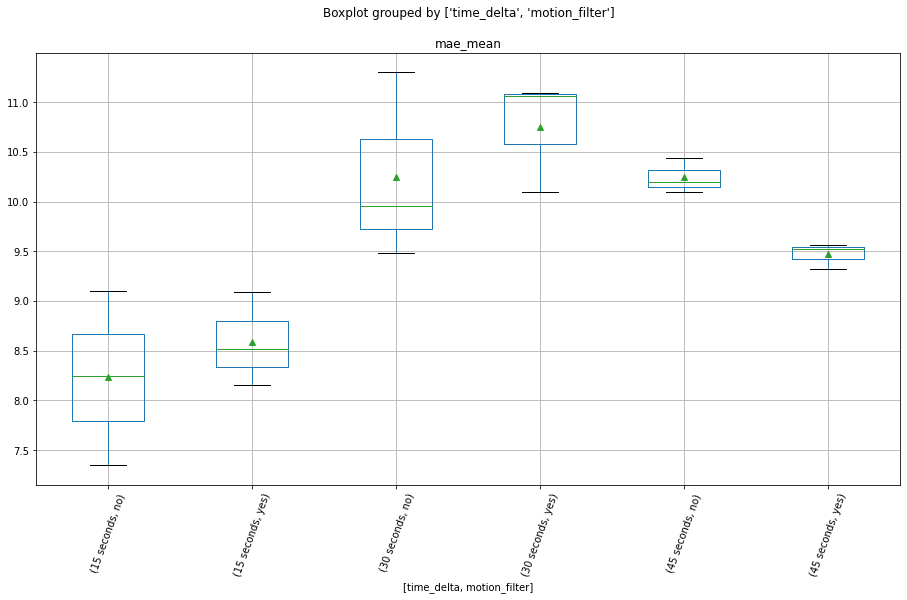

In [60]:
lgbm_biking_dbp[['experiment_type', 'predicted_variable', 'motion_filter', 'time_delta', 'mae_mean']].boxplot(
    column=['mae_mean'], by=['time_delta', 'motion_filter'], showmeans=True, figsize=(15,8))
plt.xticks(rotation=70)

In [61]:
pingouin.anova(data=lgbm_biking_dbp, dv='mae_mean', between=['time_delta', 'motion_filter'], ss_type=2, detailed=True, effsize='np2')

,Source,SS,DF,MS,F,p-unc,np2
0,time_delta,13.735818,2,6.867909,18.366127,0.000223,0.753757
1,motion_filter,0.003780,1,0.003780,0.010109,0.921573,0.000842
2,time_delta * motion_filter,1.467282,2,0.733641,1.961899,0.183150,0.246411
3,Residual,4.487332,12,0.373944,NaN,NaN,NaN


In [62]:
tt_lgbm_biking_dbp = pingouin.pairwise_ttests(data=lgbm_biking_dbp, 
                                              dv='mae_mean', subject='experiment', 
                                              between=['time_delta', 'motion_filter'],
                                             return_desc=True)

In [63]:
tt_lgbm_biking_dbp[['time_delta','A','B','p-unc',
               'mean(A)','std(A)','mean(B)','std(B)']].round(2)

,time_delta,A,B,p-unc,mean(A),std(A),mean(B),std(B)
0,-,15 seconds,30 seconds,0.00,8.41,0.66,10.50,0.75
1,-,15 seconds,45 seconds,0.00,8.41,0.66,9.86,0.45
2,-,30 seconds,45 seconds,0.10,10.50,0.75,9.86,0.45
3,-,no,yes,0.96,9.57,1.20,9.60,1.01
4,15 seconds,no,yes,0.57,8.23,0.88,8.59,0.47
5,30 seconds,no,yes,0.47,10.25,0.94,10.75,0.57
6,45 seconds,no,yes,0.00,10.24,0.18,9.47,0.13


In [64]:
pd.concat([tt_lgbm_biking_sbp[['time_delta','A','B','p-unc',]].round(3), 
           tt_lgbm_biking_dbp[['p-unc']].round(3),
           tt_lgbm_24_sbp[['p-unc']].round(3),
           tt_lgbm_24_dbp[['p-unc']].round(3)], axis=1)

,time_delta,A,B,p-unc,p-unc,p-unc,p-unc
0,-,15 seconds,30 seconds,0.251,0.000,0.390,0.855
1,-,15 seconds,45 seconds,0.031,0.001,0.181,0.427
2,-,30 seconds,45 seconds,0.001,0.101,0.366,0.149
3,-,no,yes,0.414,0.956,0.043,0.085
4,15 seconds,no,yes,0.372,0.568,0.030,0.080
5,30 seconds,no,yes,0.788,0.471,0.721,0.462
6,45 seconds,no,yes,0.123,0.004,0.556,0.503


### Data in Table 5

In [65]:
pd.concat([tt_lgbm_biking_sbp[['time_delta','A','B','mean(A)','mean(B)', 'p-unc']].round(3), 
           tt_lgbm_biking_dbp[['mean(A)','mean(B)', 'p-unc']].round(3),
           tt_lgbm_24_sbp[['mean(A)','mean(B)', 'p-unc']].round(3),
           tt_lgbm_24_dbp[['mean(A)','mean(B)', 'p-unc']].round(3)], axis=1)

,time_delta,A,B,mean(A),mean(B),p-unc,mean(A),mean(B),p-unc,mean(A),mean(B),p-unc,mean(A),mean(B),p-unc
0,-,15 seconds,30 seconds,12.725,12.097,0.251,8.410,10.498,0.000,19.073,18.652,0.390,13.949,13.872,0.855
1,-,15 seconds,45 seconds,12.725,13.866,0.031,8.410,9.856,0.001,19.073,18.440,0.181,13.949,13.618,0.427
2,-,30 seconds,45 seconds,12.097,13.866,0.001,10.498,9.856,0.101,18.652,18.440,0.366,13.872,13.618,0.149
3,-,no,yes,12.685,13.107,0.414,9.574,9.602,0.956,19.045,18.398,0.043,14.048,13.578,0.085
4,15 seconds,no,yes,12.321,13.130,0.372,8.232,8.588,0.568,19.887,18.258,0.030,14.612,13.287,0.080
5,30 seconds,no,yes,12.199,11.995,0.788,10.246,10.751,0.471,18.734,18.570,0.721,13.986,13.759,0.462
6,45 seconds,no,yes,13.535,14.196,0.123,10.243,9.469,0.004,18.515,18.365,0.556,13.547,13.688,0.503


# Special Filter

In [66]:
display(pingouin.anova(data=lgbm_24_sbp, dv='mae_mean', between=['motion_filter','special_filter'], ss_type=2, detailed=True, effsize='np2'))

display(pingouin.anova(data=lgbm_24_dbp, dv='mae_mean', between=['motion_filter','special_filter'], ss_type=2, detailed=True, effsize='np2'))

display(pingouin.anova(data=lgbm_biking_sbp, dv='mae_mean', between=['motion_filter','special_filter'], ss_type=2, detailed=True, effsize='np2'))

display(pingouin.anova(data=lgbm_biking_sbp, dv='mae_mean', between=['motion_filter','special_filter'], ss_type=2, detailed=True, effsize='np2'))

,Source,SS,DF,MS,F,p-unc,np2
0,motion_filter,1.888684,1,1.888684,4.706762,0.050840,0.281728
1,special_filter,0.422457,2,0.211228,0.526399,0.603762,0.080657
2,motion_filter * special_filter,1.046954,2,0.523477,1.304550,0.307147,0.178594
3,Residual,4.815244,12,0.401270,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,motion_filter,0.993376,1,0.993376,3.099650,0.103747,0.205280
1,special_filter,0.567776,2,0.283888,0.885821,0.437697,0.128644
2,motion_filter * special_filter,0.308991,2,0.154495,0.482075,0.628961,0.074370
3,Residual,3.845761,12,0.320480,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,motion_filter,0.800095,1,0.800095,0.686923,0.423392,0.054144
1,special_filter,2.432139,2,1.216069,1.044058,0.381918,0.148218
2,motion_filter * special_filter,1.751138,2,0.875569,0.751721,0.492516,0.111338
3,Residual,13.977033,12,1.164753,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,motion_filter,0.800095,1,0.800095,0.686923,0.423392,0.054144
1,special_filter,2.432139,2,1.216069,1.044058,0.381918,0.148218
2,motion_filter * special_filter,1.751138,2,0.875569,0.751721,0.492516,0.111338
3,Residual,13.977033,12,1.164753,NaN,NaN,NaN


In [67]:
display(pingouin.anova(data=lgbm_24_sbp, dv='mae_mean', between=['time_delta','special_filter'], ss_type=2, detailed=True, effsize='np2'))

display(pingouin.anova(data=lgbm_24_dbp, dv='mae_mean', between=['time_delta','special_filter'], ss_type=2, detailed=True, effsize='np2'))

display(pingouin.anova(data=lgbm_biking_sbp, dv='mae_mean', between=['time_delta','special_filter'], ss_type=2, detailed=True, effsize='np2'))

display(pingouin.anova(data=lgbm_biking_dbp, dv='mae_mean', between=['time_delta','special_filter'], ss_type=2, detailed=True, effsize='np2'))

,Source,SS,DF,MS,F,p-unc,np2
0,time_delta,1.243535,2,0.621768,0.933736,0.428068,0.171840
1,special_filter,0.422457,2,0.211228,0.317211,0.735996,0.065850
2,time_delta * special_filter,0.514315,4,0.128579,0.193092,0.935930,0.079036
3,Residual,5.993031,9,0.665892,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,time_delta,0.361662,2,0.180831,0.450537,0.650910,0.091008
1,special_filter,0.567776,2,0.283888,0.707301,0.518441,0.135829
2,time_delta * special_filter,1.174154,4,0.293539,0.731345,0.592908,0.245307
3,Residual,3.612312,9,0.401368,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,time_delta,9.648321,2,4.824160,8.367151,0.008847,0.650272
1,special_filter,2.432139,2,1.216069,2.109183,0.177334,0.319129
2,time_delta * special_filter,1.690910,4,0.422727,0.733190,0.591851,0.245774
3,Residual,5.189035,9,0.576559,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,time_delta,13.735818,2,6.867909,28.854682,0.000122,0.865086
1,special_filter,0.039120,2,0.019560,0.082178,0.921791,0.017934
2,time_delta * special_filter,3.777120,4,0.944280,3.967278,0.039948,0.638105
3,Residual,2.142154,9,0.238017,NaN,NaN,NaN


# 15 seconds with motion filter and norm filter

In [68]:
lgbm[['experiment_type','predicted_variable',
      'special_filter', 'mae_mean']].loc[(lgbm.time_delta == '15 seconds') & 
        (lgbm.experiment_type == '24 Hours') &
         (lgbm.motion_filter == 'yes')].groupby(['experiment_type','predicted_variable', 
                                                'special_filter']).mean().sort_values(by=['mae_mean'])

mae_mean
experiment_type predicted_variable special_filter           
24 Hours        DBP                norm            12.580623
                                   cheby           13.196300
                                   butter          14.085385
                SBP                norm            17.924938
                                   cheby           18.227380
                                   butter          18.620583

In [69]:
lgbm.loc[(lgbm.time_delta == '15 seconds') & 
         (lgbm.motion_filter == 'yes') &
         (lgbm.special_filter == 'norm') &
        (lgbm.experiment_type == '24 Hours')]

,experiment,predicted_variable,experiment_type,mae_mean,mae_std,special_filter,time_delta,time_delta_type,motion_filter,bp_pairs,mean_train_size,mean_test_size,subjects,features,model_name
13,13,DBP,24 Hours,12.580623,4.136858,norm,15 seconds,bfill,yes,132,118,14,9,9,lgbm
49,49,SBP,24 Hours,17.924938,5.257668,norm,15 seconds,bfill,yes,132,118,14,9,9,lgbm


# 15 seconds without motion filter and cheby filter

In [70]:
lgbm[['experiment_type','predicted_variable',
      'special_filter', 'mae_mean']].loc[(lgbm.time_delta == '15 seconds') & 
        (lgbm.experiment_type == 'biking') &
         (lgbm.motion_filter == 'no')].groupby(['experiment_type','predicted_variable', 
                                                'special_filter']).mean().sort_values(by=['mae_mean'])

mae_mean
experiment_type predicted_variable special_filter           
biking          DBP                cheby            7.349190
                                   norm             8.244518
                                   butter           9.100821
                SBP                cheby           11.328386
                                   butter          12.564221
                                   norm            13.068951

In [71]:
lgbm.loc[(lgbm.time_delta == '15 seconds') & 
         (lgbm.motion_filter == 'no') &
         (lgbm.special_filter == 'cheby') &
        (lgbm.experiment_type == 'biking')]

,experiment,predicted_variable,experiment_type,mae_mean,mae_std,special_filter,time_delta,time_delta_type,motion_filter,bp_pairs,mean_train_size,mean_test_size,subjects,features,model_name
24,24,DBP,biking,7.349190,4.346125,cheby,15 seconds,bfill,no,54,47,7,8,5,lgbm
60,60,SBP,biking,11.328386,6.193131,cheby,15 seconds,bfill,no,54,47,7,8,5,lgbm
